In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from google.colab import drive
drive.mount('/content/drive')
device='cuda' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.get_device_name(0))

Mounted at /content/drive
Tesla P100-PCIE-16GB


In [2]:
# x=np.load('/content/drive/MyDrive/gnn/data/dc118_p10_x.npy')
# y=np.load('/content/drive/MyDrive/gnn/data/dc118_p10_y.npy')
# All cases
x=np.load('/content/drive/MyDrive/gnn/data/ac118_p10_x.npy')
y=np.load('/content/drive/MyDrive/gnn/data/ac118_p10_y.npy')
# Normal cases
x=np.load('/content/drive/MyDrive/gnn/data/ac118_p10_x_normal1.npy')
y=np.load('/content/drive/MyDrive/gnn/data/ac118_p10_y_normal1.npy')
W=np.load('/content/drive/MyDrive/gnn/data/ac118_p10_w.npy')
gpw=(W!=0).astype(int)
print(x.shape,y.shape)
print(np.max(x),np.min(x),np.max(y),np.min(y))
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x.transpose(),y.transpose(),test_size=0.2, random_state=18)
x_train=x_train.transpose()
x_test=x_test.transpose()
y_train=y_train.transpose()
y_test=y_test.transpose()
print('Training data size:',x_train.shape)
print('Training label size:',y_train.shape)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, features, labels, device='cpu'):
        self.features=torch.from_numpy(np.transpose(features)).float().to(device)
        self.labels=torch.from_numpy(np.transpose(labels)).float().to(device)
    def __len__(self):
        return len(self.features)
    def __getitem__(self, idx):
        if torch.is_tensor(idx): idx = idx.tolist()
        # Select sample
        X = self.features[idx]  # shape = (24,)
        y = self.labels[idx]    # shape = (24,)
        X = torch.reshape(X.t(),(1,-1))
        y = torch.reshape(y,(1,118))
        return X, y
params = {'batch_size': 200,
          'shuffle': True,
          'num_workers': 0}
# Dataset Generators
training_set = Dataset(features=x_train,labels=y_train,device=device)
training_generator = torch.utils.data.DataLoader(training_set,**params)
validation_set = Dataset(features=x_test,labels=y_test,device=device)
validation_generator = torch.utils.data.DataLoader(validation_set,**params)

(118, 3, 10000) (118, 10000)
1418.3 0.0 45.778 13.030999999999999
Training data size: (118, 3, 8000)
Training label size: (118, 8000)


* Normalize the power of Laplacian

In [3]:
W1 = W.copy()
W1 = np.asarray(W1)
# print(np.asarray([[2,3],[4,7]])/5)
W1 = W1 / 1
W2 = W1.copy()
print(type(W))
lam,v = np.linalg.eig(W1)
print(lam[0])
for i in range(5):
  W1 = np.matmul(W1,W2) / np.max(np.matmul(W1,W2))
  # print(W1)
  lam,v = np.linalg.eig(W1)
  print(lam[0])#/10**(i+1))

<class 'numpy.ndarray'>
10.391198194095404
1.1997444434330222
1.2195765287586433
1.2295963414197528
1.2352295835641862
1.2386748374057457


In [4]:
from torch.autograd import Variable
# One layer Graph convolution from nodes to edges
class graph_prune(nn.Module):
    def __init__(self,in_features,out_features,w,bias=True):
        super(graph_prune,self).__init__()
        # enlarge w
        W=np.zeros([w.shape[0]*in_features,w.shape[0]*out_features])
        for i in range(w.shape[0]):
          for j in range(w.shape[1]):
            W[i*in_features:(i+1)*in_features,j*out_features:(j+1)*out_features]+=1
        self.register_buffer('w',torch.from_numpy(W).float())
        self.mapping=nn.Parameter(torch.Tensor(W.shape[0],W.shape[1]))
        self.bias=nn.Parameter(torch.Tensor(1,W.shape[1]))
        torch.nn.init.xavier_uniform_(self.mapping.data)
        torch.nn.init.xavier_uniform_(self.bias.data)

    def forward(self,input):
        h=torch.mul(self.mapping,self.w)
        h=torch.matmul(input,h)
        h=h+self.bias
        return h 

# graph prune NN
class GP(nn.Module):
    def __init__(self, in_feats, hidden_size, W, num_bus):
        super(GP, self).__init__()
        self.conv_v2v1=graph_prune(in_feats,hidden_size[0],W)
        self.conv_v2v2=graph_prune(hidden_size[0],hidden_size[1],W)
        self.conv_v2v3=graph_prune(hidden_size[1],hidden_size[2],W)
        self.conv_v2v4=graph_prune(hidden_size[2],hidden_size[3],W)
        self.conv_v2v5=graph_prune(hidden_size[3],hidden_size[4],W)
        self.conv_v2v6=graph_prune(hidden_size[4],hidden_size[5],W)
        self.lin_output = nn.Linear(num_bus,num_bus)
         
    def forward(self, inputs):
        # m = nn.ELU()
        # m = nn.LeakyReLU()
        # m = nn.Tanh()
        m = nn.ReLU()
        h=self.conv_v2v1(inputs)
        h=m(h)
        h=self.conv_v2v2(h)
        h=m(h)
        h=self.conv_v2v3(h)
        h=m(h)
        h=self.conv_v2v4(h)
        h=m(h)
        h=self.conv_v2v5(h)
        h=m(h)
        h=self.conv_v2v6(h)
        h=m(h)
        # h=torch.relu(h)
        h = self.lin_output(h)
        # time.sleep(5)
        return h
n_bus=x.shape[0]
# w_params=[10,15,10,1]
w_params=[10,15,15,10,10,1]
net=GP(3,w_params,gpw,n_bus) # Laplacian
net=net.to(device)

# set loss_func & optimizer
loss_func=nn.MSELoss()
def my_loss_func(pred,label,W1):
  mse=loss_func(pred,label)
  lmda1=torch.from_numpy(np.array([1])).to(device) # L_2
  lmda2=torch.from_numpy(np.array([0.01])).to(device) # L_inf
  # lmda3=torch.from_numpy(np.array([0.02])).to(device) # locality
  linf=(pred-label).norm(p=float('inf'))
  # locality = torch.matmul(torch.matmul(pred,W1),pred.transpose(1,2))
  # print(pred.shape,pred.transpose(1,2).shape)
  return lmda1*mse + lmda2*linf #+ lmda3*torch.mean(locality) # mean/sum over batch
  # return mse
optimizer=torch.optim.Adam(net.parameters(),weight_decay=0.001)
loss_optm=[]
loss_val=[]
print(net)
# n_params = 0
# n_params_trainable = 0
# for temp in net.parameters():
#     # print(temp.shape[0])
#     # print(temp.shape)
#     n_params += temp.shape[0] * temp.shape[1]
#     if abs(temp.shape[0] - n_bus) > 0:
#       n_params_trainable += temp.shape[0] * temp.shape[1]
#     else:
#       n_params_trainable += n_bus + 2 * n_line
# print('Number of GNN parameters:',n_params)
# print('Number of effective GNN parameters:',n_params_trainable)

GP(
  (conv_v2v1): graph_prune()
  (conv_v2v2): graph_prune()
  (conv_v2v3): graph_prune()
  (conv_v2v4): graph_prune()
  (conv_v2v5): graph_prune()
  (conv_v2v6): graph_prune()
  (lin_output): Linear(in_features=118, out_features=118, bias=True)
)


In [5]:
max_epochs=200
eval_epoch=5

# earlystopping
tolerance= 4
min_delta=5e-4
previous=0

W_tensor = torch.from_numpy(W).float().to(device)
for epoch in range(max_epochs):
  # training loop
  train_loss=0.0
  for local_batch,local_label in training_generator:
    optimizer.zero_grad() # clear the past gradient
    # print(local_batch.shape)
    # print(local_batch)
    # print(local_label.shape)
    logits=net(local_batch)
    loss=my_loss_func(logits,local_label,W_tensor)
    loss.backward()
    train_loss+=loss.item()
    optimizer.step() # update parameters of net
  loss_optm.append(train_loss/len(training_generator.dataset))
  print("Epoch %d | Training loss: %.4f"%(epoch,train_loss/len(training_generator.dataset)))
  # eval
  if (epoch+1)%eval_epoch==0:
    net.eval()
    eval_loss=0.0
    for eval_batch,eval_label in validation_generator:
      eval_batch,eval_label=eval_batch.to(device),eval_label.to(device)
      logits=net(eval_batch)
      loss=loss_func(logits,eval_label)
      eval_loss+=loss.item()
    eval_avg=eval_loss/len(validation_generator.dataset)
    if (epoch==0): previous=eval_avg
    else:
      if previous-eval_avg<min_delta: tolerance-=1
      if tolerance==0: break
      previous=eval_avg
    print("Epoch %d | Eval loss: %.4f" % (epoch, eval_avg))
    loss_val.append([epoch, eval_loss/len(validation_generator.dataset)])
    net.train()
  # validation loop
  with torch.set_grad_enabled(False):
      pass

Epoch 0 | Training loss: 1.2285
Epoch 1 | Training loss: 0.0441
Epoch 2 | Training loss: 0.0368
Epoch 3 | Training loss: 0.0325
Epoch 4 | Training loss: 0.0424
Epoch 4 | Eval loss: 0.0441
Epoch 5 | Training loss: 0.0366
Epoch 6 | Training loss: 0.0317
Epoch 7 | Training loss: 0.0316
Epoch 8 | Training loss: 0.0293
Epoch 9 | Training loss: 0.0363
Epoch 9 | Eval loss: 0.0291
Epoch 10 | Training loss: 0.0263
Epoch 11 | Training loss: 0.0267
Epoch 12 | Training loss: 0.0408
Epoch 13 | Training loss: 0.0258
Epoch 14 | Training loss: 0.0265
Epoch 14 | Eval loss: 0.0242
Epoch 15 | Training loss: 0.0238
Epoch 16 | Training loss: 0.0374
Epoch 17 | Training loss: 0.0303
Epoch 18 | Training loss: 0.0256
Epoch 19 | Training loss: 0.0240
Epoch 19 | Eval loss: 0.0242
Epoch 20 | Training loss: 0.0231
Epoch 21 | Training loss: 0.0320
Epoch 22 | Training loss: 0.0259
Epoch 23 | Training loss: 0.0240
Epoch 24 | Training loss: 0.0230
Epoch 24 | Eval loss: 0.0210
Epoch 25 | Training loss: 0.0241
Epoch 26 

In [6]:
print(len(loss_val))
print(loss_val[0][0])
# print(val_plt)
print(logits.shape,eval_label.shape)

8
4
torch.Size([200, 1, 118]) torch.Size([200, 1, 118])


8


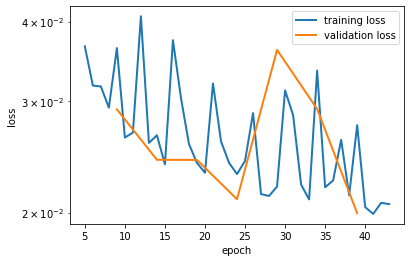

In [7]:
import matplotlib.pyplot as plt

val_len = len(loss_val)
print(val_len)
val_plt = np.zeros((2,val_len))
for i in range(val_len):
  val_plt[0,i] = loss_val[i][0]
  val_plt[1,i] = loss_val[i][1]

plt.figure()
plot_idx = np.arange(np.size(loss_optm))
# plt.plot(plot_idx,loss_optm,lw=2,label='training loss')
# plt.plot(val_plt[0,:],val_plt[1,:],lw=2,label='validation loss')
plt.plot(plot_idx[5:-1],loss_optm[5:-1],lw=2,label='training loss')
plt.plot(val_plt[0,1:],val_plt[1,1:],lw=2,label='validation loss')
plt.yscale("log")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show(block=False)

# Evaluate the model w/ validation set

In [8]:
# local_batch, local_labels = local_batch.to(device), local_labels.to(device)
# print(local_batch.shape)
# x_test_feed = x_test_feed.unsqueeze_(-1).transpose(1,2)
# print(x_test_feed.shape)
print(local_batch.shape)

torch.Size([200, 1, 354])


In [9]:
# validation_set = Dataset(features=x_test, labels=y_test)
# validation_generator = torch.utils.data.DataLoader(validation_set, **params)
# for local_batch, local_labels in validation_generator:
#   # Transfer to GPU
#   local_batch, local_labels = local_batch.to(device), local_labels.to(device)
#   logits = net(local_batch)

n_test = 2000

x_test_feed = torch.from_numpy(np.transpose(x_test)).float()
x_test_feed = torch.transpose(x_test_feed,1,2).reshape(n_test,1,-1)
x_test_feed = x_test_feed.transpose(1,1)
x_test_feed = x_test_feed.to(device)
print('Validation dataset size:',x_test_feed.shape)
print('Number of validation set: ',n_test)
# y_pred = np.zeros((x_test_feed.shape))
# for i in range(n_test):
#   y_pred[i,:] = net(x_test_feed[i,:])
y_pred = net(x_test_feed)

Validation dataset size: torch.Size([2000, 1, 354])
Number of validation set:  2000


* Visualization




 - Visualize errors

In [10]:
y_pred1 = y_pred.cpu().detach()
y_pred1 = torch.squeeze(y_pred1,1).numpy().transpose()
print(y_test.shape)

(118, 2000)


In [11]:
print(y_test.shape,y_pred1.shape)

(118, 2000) (118, 2000)


In [12]:
# for i in range(5):
#   print('sample',i)
#   print(y_test[:,i])
#   print(y_pred1[:,i])

In [13]:
n_test = np.size(y_test,1)
err_L2 = np.zeros(n_test)
err_Linf = np.zeros(n_test)
for i in range(n_test):
  err_L2[i] = np.linalg.norm(y_test[:,i] - y_pred1[:,i]) / np.linalg.norm(y_test[:,i])
  err_Linf[i] = np.max(np.abs(y_test[:,i] - y_pred1[:,i])) / np.max(np.abs(y_test[:,i]))

In [14]:
y_test

array([[32.727, 35.499, 30.131, ..., 34.177, 31.541, 33.721],
       [32.447, 35.343, 30.107, ..., 33.993, 31.35 , 33.559],
       [32.3  , 35.011, 29.789, ..., 33.644, 31.156, 33.225],
       ...,
       [28.666, 29.25 , 27.101, ..., 28.189, 28.299, 31.042],
       [32.386, 35.609, 30.368, ..., 33.97 , 31.298, 33.449],
       [30.522, 29.971, 28.053, ..., 30.385, 30.267, 33.088]])

In [15]:
print(err_L2.shape,err_Linf.shape)

(2000,) (2000,)


L2 mean: 0.0727791049944025 L_inf mean: 0.1336541162340467


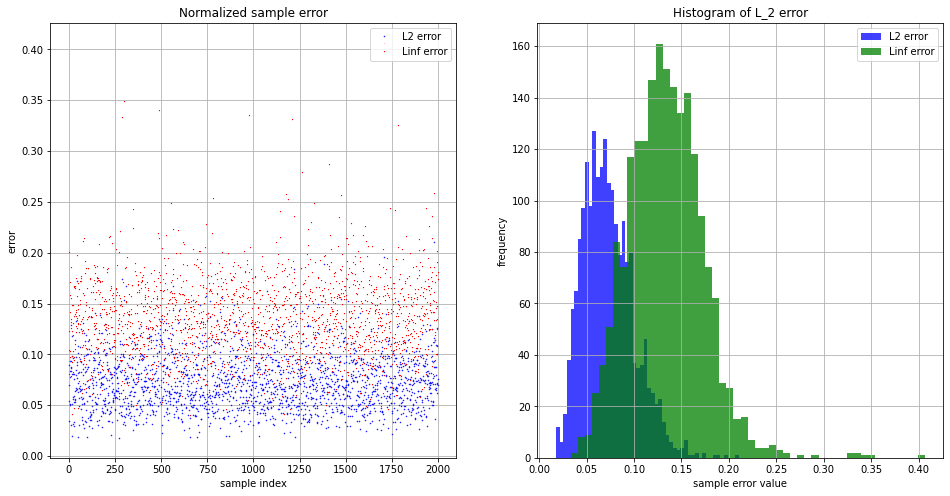

In [16]:
err_L2_mean = np.mean(err_L2)
err_Linf_mean = np.mean(err_Linf)
print('L2 mean:', err_L2_mean,'L_inf mean:', err_Linf_mean )

fig2 = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
# plt.hist(np.abs(ga),bins = 10)
plt.plot(err_L2,'bo',markersize=0.5,label = 'L2 error')
plt.plot(err_Linf,'r^',markersize=0.5,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample index')
plt.ylabel('error')
plt.title('Normalized sample error')
plt.grid(True)
# error histogram
plt.subplot(1, 2, 2)
plt.hist(err_L2, bins = 50, facecolor='b', alpha=0.75,label = 'L2 error')
plt.hist(err_Linf, bins = 50, facecolor='g', alpha=0.75,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample error value')
plt.ylabel('frequency')
plt.title('Histogram of L_2 error')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

2000 L2 mean: 0.0727791049944025 2000 L_inf mean: 0.1336541162340467


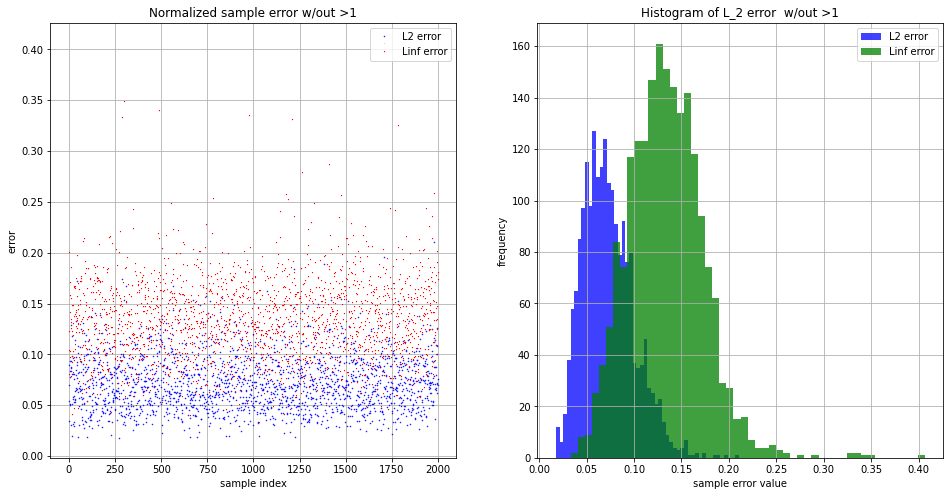

In [17]:
err_l2_new = [i for i in err_L2 if i < 1]
err_linf_new = [i for i in err_Linf if i < 1]
print(len(err_l2_new),'L2 mean:', np.mean(err_l2_new),len(err_linf_new),'L_inf mean:', np.mean(err_linf_new) )

fig2 = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
# plt.hist(np.abs(ga),bins = 10)
plt.plot(err_l2_new,'bo',markersize=0.5,label = 'L2 error')
plt.plot(err_linf_new,'r^',markersize=0.5,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample index')
plt.ylabel('error')
plt.title('Normalized sample error w/out >1')
plt.grid(True)
# error histogram
plt.subplot(1, 2, 2)
plt.hist(err_l2_new, bins = 50, facecolor='b', alpha=0.75,label = 'L2 error')
plt.hist(err_linf_new, bins = 50, facecolor='g', alpha=0.75,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample error value')
plt.ylabel('frequency')
plt.title('Histogram of L_2 error  w/out >1')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

In [18]:
print(x_train.shape)
# print(x_train[:,:,1].transpose())
# print(np.max(gen_limit0),np.min(err_linf_new))

(118, 3, 8000)


In [19]:
# print(y_test[:,1], y_pred1[:,1])
index = 1
y_test_copy = y_pred1[:,index].copy()
print(y_test_copy.shape)
for i in range(118):
  if y_test_copy[i] < 0.1:
    y_test_copy[i] = y_test[i,index] + 50

print(np.linalg.norm(y_test_copy - y_test[:,index]) / np.linalg.norm(y_test[:,index]))

(118,)
0.03434147413473564


In [20]:
# y_test_copy
# y_pred1[:,index]

# Predict generation using $\pi$
* Using predicted $\pi$ and find the active constraints in $p_G(i)$
* For inactive $p_G(i)$ consider other methods like power flow balance

In [21]:
gen_limit0 = x[:,2,:].copy()
print(gen_limit0.shape)

gen_idx = []
for i in range(n_bus):
  if gen_limit0[i,0] > 0:
    gen_idx.append(i)
print(type(gen_idx),len(gen_idx),gen_idx)

(118, 10000)
<class 'list'> 19 [9, 11, 24, 25, 30, 45, 48, 53, 58, 60, 64, 65, 68, 79, 86, 88, 99, 102, 110]


In [22]:
# # get the generator index
# # generator cost data
# gen_cost0
# # generator limit data
# gen_limit0
# # LMP data
# lmp_data
# # generation data
# gen_data

load_data = x.copy()
print(load_data.shape)
n_sample = np.size(load_data,2)

n_val=10000

x_val_feed = torch.from_numpy(np.transpose(load_data)).float()
x_val_feed = x_val_feed.to(device)
x_val_feed=x_val_feed.transpose(1,2).reshape(n_val,1,-1)

print('Dataset size:',x_val_feed.shape)
print('Number of validation points:: ',n_sample)
y_pred = net(x_val_feed) # predict the corredponding LMP

y_pred1 = y_pred.cpu().detach()
y_pred1 = torch.squeeze(y_pred1,1).numpy().transpose()

(118, 3, 10000)
Dataset size: torch.Size([10000, 1, 354])
Number of validation points::  10000


* Save results

In [23]:
import pickle

In [24]:
# dataset = {'lmp_pred': y_pred1, 'lmp_true': lmp_data}
# print('Pred:',y_pred1.shape,'True:',lmp_data.shape)

# file_name = 'dc118_lmp_prediction_p10'
# file_path = 'drive/My Drive/gnn/data/results/'
# file_dir = file_path + file_name + '.pickle'
# outfile = open(file_dir, 'wb')
# pickle.dump(dataset, outfile)
# outfile.close()

In [25]:
gen_cost0 = x[:,1,:].copy()
lmp_data = y.copy()

profit_pred = y_pred1 - gen_cost0
print(np.min(np.abs(profit_pred)))

profit_true = lmp_data - gen_cost0

5.770874023269812e-05


In [26]:
gen_pred_binary = np.zeros((len(gen_idx),n_sample))
gen_true_binary = np.zeros((len(gen_idx),n_sample))
print(gen_pred_binary.shape)

binary_thres = 0.97
binary_thres_true = 1e-5

for i in range(n_sample):
  for j in range(len(gen_idx)):
    # predicted generator limit
    if profit_pred[gen_idx[j],i] > binary_thres:
      gen_pred_binary[j,i] = 1
    elif profit_pred[gen_idx[j],i] < 1-binary_thres:
      gen_pred_binary[j,i] = 0
    else:
      gen_pred_binary[j,i] = 0.5
    # true generator limit
    if profit_true[gen_idx[j],i] > binary_thres_true:
      gen_true_binary[j,i] = 1
    elif profit_true[gen_idx[j],i] < 1e-5:
      gen_true_binary[j,i] = 0
    else:
      gen_true_binary[j,i] = 0.5


(19, 10000)


In [27]:
gen_binary_err = np.abs(gen_true_binary - gen_pred_binary)
print('max binary error:',np.max(gen_binary_err))
# count the wrong entries
gen_binary_err_ct = np.sum(gen_binary_err)
gen_binary_err_ratio = gen_binary_err_ct / (len(gen_idx)*n_sample)
print('Binary accuracy:',1-gen_binary_err_ratio)


max binary error: 1.0
Binary accuracy: 0.8449973684210527


In [28]:
print(gen_limit0.shape)
print(np.transpose(x_test).shape,np.transpose(load_data).shape)

(118, 10000)
(2000, 3, 118) (10000, 3, 118)
